# Francisco Alfredo Castrellon Carrillo
# David Gamaliel Arcos Bravo

In [1]:
import sys
import numpy as np
from numpy.fft import fft2, fftshift, ifft2, ifftshift
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cv2
from collections import defaultdict, deque
from scipy import ndimage as ndi

from copy import deepcopy
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from numba import jit, cuda
import warnings
warnings.filterwarnings("ignore")

## Parte 1

In [2]:
def mergeImages(img1, img2, mask, nLayers=6):
    #Create Gaussian pyramids
    gp1 = [img1.copy()]
    for i in range(nLayers): gp1.append(cv2.pyrDown(gp1[i]))
    gp2 = [img2.copy()]
    for i in range(nLayers): gp2.append(cv2.pyrDown(gp2[i]))

    #Create Laplacian pyramids
    lp1 = [gp1[nLayers-1]]
    for i in range(nLayers-1, 0, -1): lp1.append( cv2.subtract( gp1[i-1], cv2.pyrUp(gp1[i], dstsize=(gp1[i-1].shape[1],gp1[i-1].shape[0])) ) )
    lp2 = [gp2[nLayers-1]]
    for i in range(nLayers-1, 0, -1): lp2.append( cv2.subtract( gp2[i-1], cv2.pyrUp(gp2[i], dstsize=(gp2[i-1].shape[1],gp2[i-1].shape[0])) ) )

    #Merge images
    merged = []
    for la,lb in zip(lp1,lp2):
        #Resize mask for each layer
        maskR = cv2.resize(mask, (la.shape[1], la.shape[0]))
        if len(la.shape) == 3: maskR = cv2.merge((maskR, maskR, maskR))
        #Combine masked layers
        merged.append( np.array((la * maskR) + (lb * (1-maskR)), dtype=np.uint8) )

    #Reconstruct
    final = merged[0]
    for i in range(1,nLayers):
        final = cv2.add(cv2.pyrUp(final, dstsize=(merged[i].shape[1],merged[i].shape[0])), merged[i])

    return final

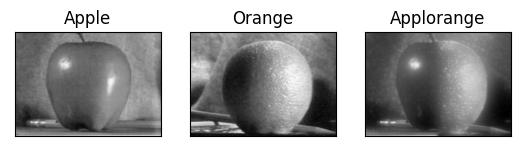

In [12]:
np.set_printoptions(threshold=sys.maxsize)
img1 = cv2.imread('images/manzana.jpg',0)
img2 = cv2.imread('images/naranja.jpg',0)

mask = np.zeros((img1.shape[0], img1.shape[1]))
mask[:, 0:int(img1.shape[1]/2)] = 1

final = mergeImages(img1, img2, mask, 6)

plt.subplot(131),plt.imshow(img1, cmap = 'gray')
plt.title('Apple'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(img2, cmap = 'gray')
plt.title('Orange'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(final, cmap = 'gray')
plt.title('Applorange'), plt.xticks([]), plt.yticks([])
plt.show()

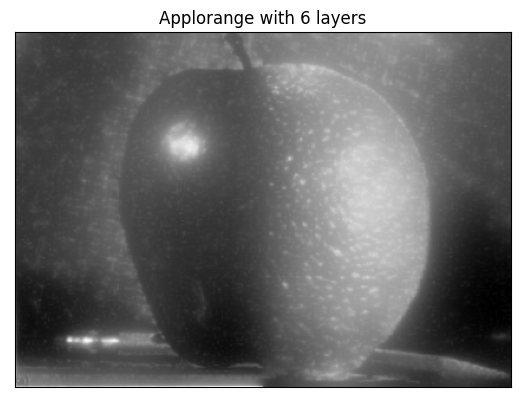

In [14]:
# Plot the final image
plt.imshow(final, cmap = 'gray')
plt.title('Applorange with 6 layers'), plt.xticks([]), plt.yticks([])
plt.show()

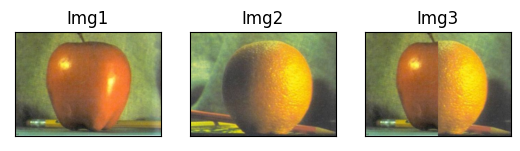

In [8]:
img1 = cv2.imread('images/manzana.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.imread('images/naranja.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

mask = np.zeros((img1.shape[0], img1.shape[1]))
mask[:, 0:int(img1.shape[1]/2)] = 1

final = mergeImages(img1, img2, mask, 3)

plt.subplot(131),plt.imshow(img1, cmap = 'gray')
plt.title('Img1'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(img2, cmap = 'gray')
plt.title('Img2'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(final, cmap = 'gray')
plt.title('Img3'), plt.xticks([]), plt.yticks([])
plt.show()

(Text(0.5, 1.0, 'Six layers'), ([], []), ([], []))

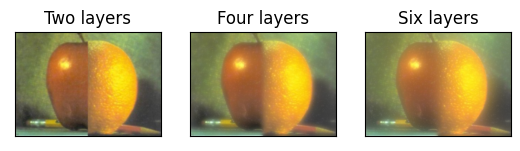

In [10]:
final_2 = mergeImages(img1, img2, mask, 2)
final_4 = mergeImages(img1, img2, mask, 4)
final_6 = mergeImages(img1, img2, mask, 6)


plt.subplot(131),plt.imshow(final_2, cmap = 'gray')
plt.title('Two layers'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(final_4, cmap = 'gray')
plt.title('Four layers'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(final_6, cmap = 'gray')
plt.title('Six layers'), plt.xticks([]), plt.yticks([])

## Parte 2

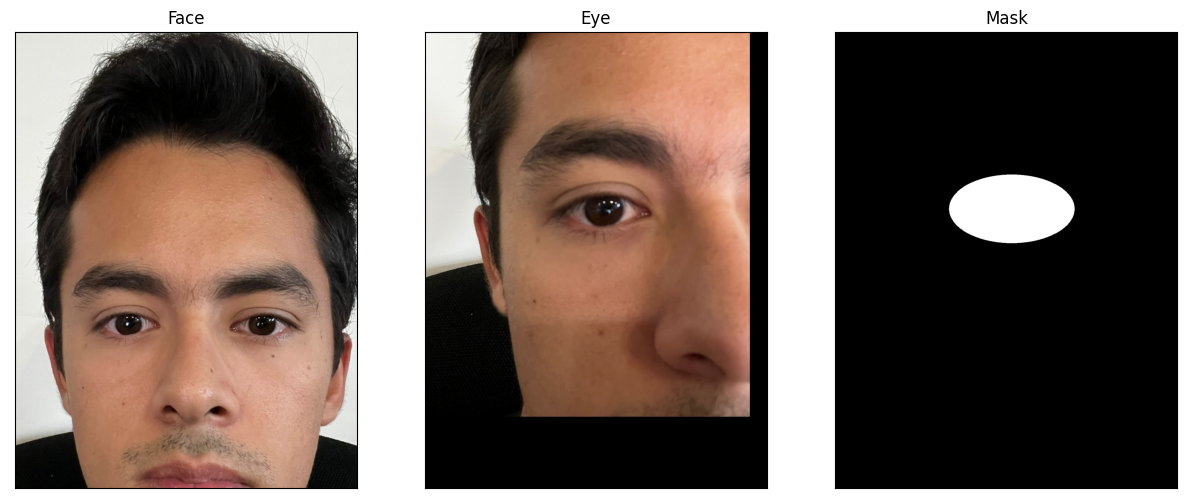

In [17]:
#Load images
face_img = cv2.imread('images/cara.jpeg')
face_img = cv2.cvtColor(face_img, cv2.COLOR_BGR2RGB)
eye_img = cv2.imread('images/ojo.jpeg')
eye_img = cv2.cvtColor(eye_img, cv2.COLOR_BGR2RGB)

ty = -250
tx = -60
eye_img = cv2.warpAffine(eye_img, np.float32([[1,0,tx],[0,1,ty]]), (eye_img.shape[1], eye_img.shape[0]))
face_img = cv2.warpAffine(face_img, np.float32([[1,0,-200],[0,1,-40]]), (face_img.shape[1], face_img.shape[0]))
ratio = 1.5
face_img = cv2.warpAffine(face_img, np.float32([[ratio,0,0],[0,ratio,0]]), (0,0))

ty = -180
tx = 20
mask = np.zeros((face_img.shape[0], face_img.shape[1]))
radius_x, radius_y = 220, 120
cv2.ellipse(mask, (face_img.shape[1]//2 + tx, face_img.shape[0]//2 + ty), (radius_x, radius_y), 0, 0, 360, 1, -1)

final = mergeImages(eye_img, face_img, mask, 7)

plt.figure(figsize=(15,15))
plt.subplot(131),plt.imshow(face_img)
plt.title('Face'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(eye_img)
plt.title('Eye'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(mask, cmap = 'gray')
plt.title('Mask'), plt.xticks([]), plt.yticks([])
plt.show()

(Text(0.5, 1.0, 'Six layers'), ([], []), ([], []))

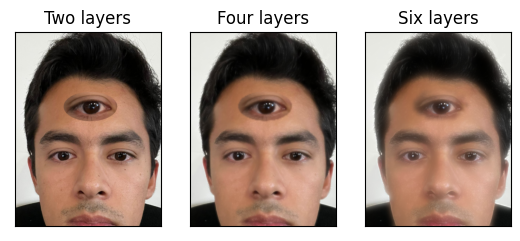

In [16]:
final_2 = mergeImages(eye_img, face_img, mask, 2)
final_4 = mergeImages(eye_img, face_img, mask, 4)
final_6 = mergeImages(eye_img, face_img, mask, 6)


plt.subplot(131),plt.imshow(final_2, cmap = 'gray')
plt.title('Two layers'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(final_4, cmap = 'gray')
plt.title('Four layers'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(final_6, cmap = 'gray')
plt.title('Six layers'), plt.xticks([]), plt.yticks([])

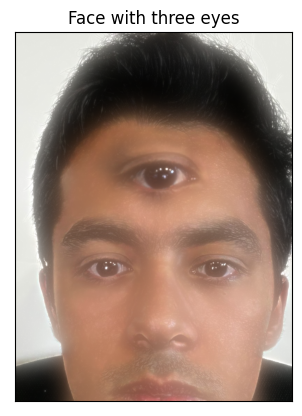

In [6]:
plt.imshow(final), plt.title('Face with three eyes'), plt.xticks([]), plt.yticks([])
plt.show()